In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import datetime
import seaborn as sns
import os
import statistics as st
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16,9]
plt.rcParams['figure.dpi'] = 300
'''

# Some of these libraries you don't need, and some libraries are imported later:
# I was just experimenting with different stuff.
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree, datasets, svm
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import itertools
from itertools import product

def read_csv(filepath):
    df = pd.read_csv(filepath, skiprows=0, error_bad_lines=False)
    df = df.iloc[::-1]#.reset_index()
    df.index = range(0, len(list(df.index)))
    return df

Gas_Data = read_csv('/Users/siddharth/Downloads/School Stuff/RBOB UGA/Gas_Data.csv')
#Gas_Data = Gas_Data.drop(labels='UGA_Close', axis=1)
Gas_Data.tail()

,Week of,All_Forms_Prices,Cushing_Crude_Futures,NY_Heating_Futures,NY_RBOB_Futures,Crude_Distillation_Capacity,Commercial_Crude_Imports,Days_of_Supply,Fuel_Ethanol_Ending,Blending_Components_Ending,...,Motor_Gasoline_Exports,RBOB_Blending_Imports,Total_Imports,Fuel_Ethanol_Production,Refinery_Utilization_Capacity,Motor_Gasoline_Supplied,Propane_Propylene_Supplied,Blending_Components_Inputs,Refinery_Crude_Inputs,Motor_Gasoline_Production
583,9/13/21,3.262,68.88,2.130,2.129,18128,5761,23.2,20010,200707,...,634,146,638,937,82.1,8892,888,557,14387,9565
584,9/20/21,3.280,71.62,2.189,2.178,18128,6465,24.0,20111,201312,...,621,187,1082,926,87.5,8896,1293,401,15347,9613
585,9/27/21,3.271,72.07,2.212,2.141,18128,6552,24.1,20220,202386,...,725,262,989,914,88.1,9399,1102,653,15415,9738
586,10/4/21,3.285,75.33,2.324,2.232,18128,7035,24.6,19931,207492,...,404,184,1088,978,89.6,9427,1281,532,15744,9745
587,10/11/21,3.360,78.33,2.461,2.335,18129,5994,24.2,19847,206846,...,699,211,543,1032,86.7,9186,1116,559,15061,9699


In [2]:
# Turning the all-grades price into a basic variable
def np_shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))
#Gas_Data['U.S. All Grades All Formulations Retail Gasoline Prices Weekly'] = np.where(np_shift(np.array(Gas_Data['U.S. All Grades All Formulations Retail Gasoline Prices Weekly']), 1) > np_shift(np.array(Gas_Data['U.S. All Grades All Formulations Retail Gasoline Prices Weekly']), 2), 1, 0)
Gas_Data['All_Forms_Prices'] = np.where(np.array(Gas_Data['All_Forms_Prices']) > np_shift(np.array(Gas_Data['All_Forms_Prices']), 1), 1, 0)
#Gas_Data.tail()

for column in Gas_Data:
    unique_vals = np.unique(Gas_Data[column])
    nr_values = len(unique_vals)
    if nr_values < 10:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values, unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))
        
Gas_Data.isnull().sum()

The number of values for feature Week of :588
The number of values for feature All_Forms_Prices :2 -- [0 1]
The number of values for feature Cushing_Crude_Futures :559
The number of values for feature NY_Heating_Futures :492
The number of values for feature NY_RBOB_Futures :508
The number of values for feature Crude_Distillation_Capacity :76
The number of values for feature Commercial_Crude_Imports :534
The number of values for feature Days_of_Supply :103
The number of values for feature Fuel_Ethanol_Ending :564
The number of values for feature Blending_Components_Ending :586
The number of values for feature Motor_Gasoline_Ending :579
The number of values for feature Total_Gasoline_Ending :583
The number of values for feature Motor_Gasoline_Exports :277
The number of values for feature RBOB_Blending_Imports :242
The number of values for feature Total_Imports :410
The number of values for feature Fuel_Ethanol_Production :263
The number of values for feature Refinery_Utilization_Capacity

Week of                          0
All_Forms_Prices                 0
Cushing_Crude_Futures            0
NY_Heating_Futures               0
NY_RBOB_Futures                  0
Crude_Distillation_Capacity      0
Commercial_Crude_Imports         0
Days_of_Supply                   0
Fuel_Ethanol_Ending              0
Blending_Components_Ending       0
Motor_Gasoline_Ending            0
Total_Gasoline_Ending            0
Motor_Gasoline_Exports           0
RBOB_Blending_Imports            0
Total_Imports                    0
Fuel_Ethanol_Production          0
Refinery_Utilization_Capacity    0
Motor_Gasoline_Supplied          0
Propane_Propylene_Supplied       0
Blending_Components_Inputs       0
Refinery_Crude_Inputs            0
Motor_Gasoline_Production        0
dtype: int64

In [ ]:
Gas_Data.columns

In [3]:
new_data = Gas_Data[['All_Forms_Prices', 'Cushing_Crude_Futures',
       'NY_Heating_Futures', 'NY_RBOB_Futures', 'Crude_Distillation_Capacity',
       'Commercial_Crude_Imports', 'Days_of_Supply', 'Fuel_Ethanol_Ending',
       'Blending_Components_Ending', 'Motor_Gasoline_Ending',
       'Total_Gasoline_Ending', 'Motor_Gasoline_Exports',
       'RBOB_Blending_Imports', 'Total_Imports', 'Fuel_Ethanol_Production',
       'Refinery_Utilization_Capacity', 'Motor_Gasoline_Supplied',
       'Propane_Propylene_Supplied', 'Blending_Components_Inputs',
       'Refinery_Crude_Inputs', 'Motor_Gasoline_Production']]

In [ ]:
# Visualize the data using seaborn Pairplots
g = sns.pairplot(new_data, hue = 'All_Forms_Prices', diag_kws={'bw': 0.2})

In [ ]:
# Use a correlation heatmap to observe correlation
corr = new_data.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, annot=True)

In [4]:
scale_vars = ['Cushing_Crude_Futures',
       'NY_Heating_Futures', 'NY_RBOB_Futures', 'Crude_Distillation_Capacity',
       'Commercial_Crude_Imports', 'Days_of_Supply', 'Fuel_Ethanol_Ending',
       'Blending_Components_Ending', 'Motor_Gasoline_Ending',
       'Total_Gasoline_Ending', 'Motor_Gasoline_Exports',
       'RBOB_Blending_Imports', 'Total_Imports', 'Fuel_Ethanol_Production',
       'Refinery_Utilization_Capacity', 'Motor_Gasoline_Supplied',
       'Propane_Propylene_Supplied', 'Blending_Components_Inputs',
       'Refinery_Crude_Inputs', 'Motor_Gasoline_Production']
scaler = MinMaxScaler()
new_data[scale_vars] = scaler.fit_transform(new_data[scale_vars])

<ipython-input-4-a6e4cde9b67d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[scale_vars] = scaler.fit_transform(new_data[scale_vars])
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [5]:
# Must skip this cell first time running
# run the feature importance scores to find the unimportant inputs
# copy/paste importances into this cell, adjust new_data accordingly
# then restart the kernel and don't skip this cell as you go.

'''
Importance of feature Cushing_Crude_Futures:, 0.000
Importance of feature NY_Heating_Futures:, 0.099
Importance of feature NY_RBOB_Futures:, 0.165
Importance of feature Crude_Distillation_Capacity:, 0.000
Importance of feature Commercial_Crude_Imports:, 0.028
Importance of feature Days_of_Supply:, 0.085
Importance of feature Fuel_Ethanol_Ending:, 0.000
Importance of feature Blending_Components_Ending:, 0.066
Importance of feature Motor_Gasoline_Ending:, 0.045
Importance of feature Total_Gasoline_Ending:, 0.000
Importance of feature Motor_Gasoline_Exports:, 0.098
Importance of feature RBOB_Blending_Imports:, 0.104
Importance of feature Total_Imports:, 0.000
Importance of feature Fuel_Ethanol_Production:, 0.046
Importance of feature Refinery_Utilization_Capacity:, 0.000
Importance of feature Motor_Gasoline_Supplied:, 0.000
Importance of feature Propane_Propylene_Supplied:, 0.000
Importance of feature Blending_Components_Inputs:, 0.000
Importance of feature Refinery_Crude_Inputs:, 0.000
Importance of feature Motor_Gasoline_Production:, 0.263
'''
new_data = new_data[['All_Forms_Prices','NY_Heating_Futures','NY_RBOB_Futures','Commercial_Crude_Imports',
                     'Days_of_Supply','Blending_Components_Ending',
                     'Motor_Gasoline_Ending','Motor_Gasoline_Exports','RBOB_Blending_Imports',
                     'Fuel_Ethanol_Production','Motor_Gasoline_Production']]

In [6]:
# Splitting data into x and y

# Input features (attributes)
X = new_data.drop('All_Forms_Prices', axis=1).values
# Target vector
Y = new_data['All_Forms_Prices'].values

print('X shape: {}'.format(np.shape(X)))
print('Y shape: {}'.format(np.shape(Y)))

'''
Hold-Out Validation
- use 90% of data to train the model
- use 10% to test, bc model has not seen this data
- allows us to select and compare the best model
'''
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, random_state=0)

X shape: (588, 10)
Y shape: (588,)


In [7]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1)
dt.fit(X_train, Y_train)

# Doc:https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1)

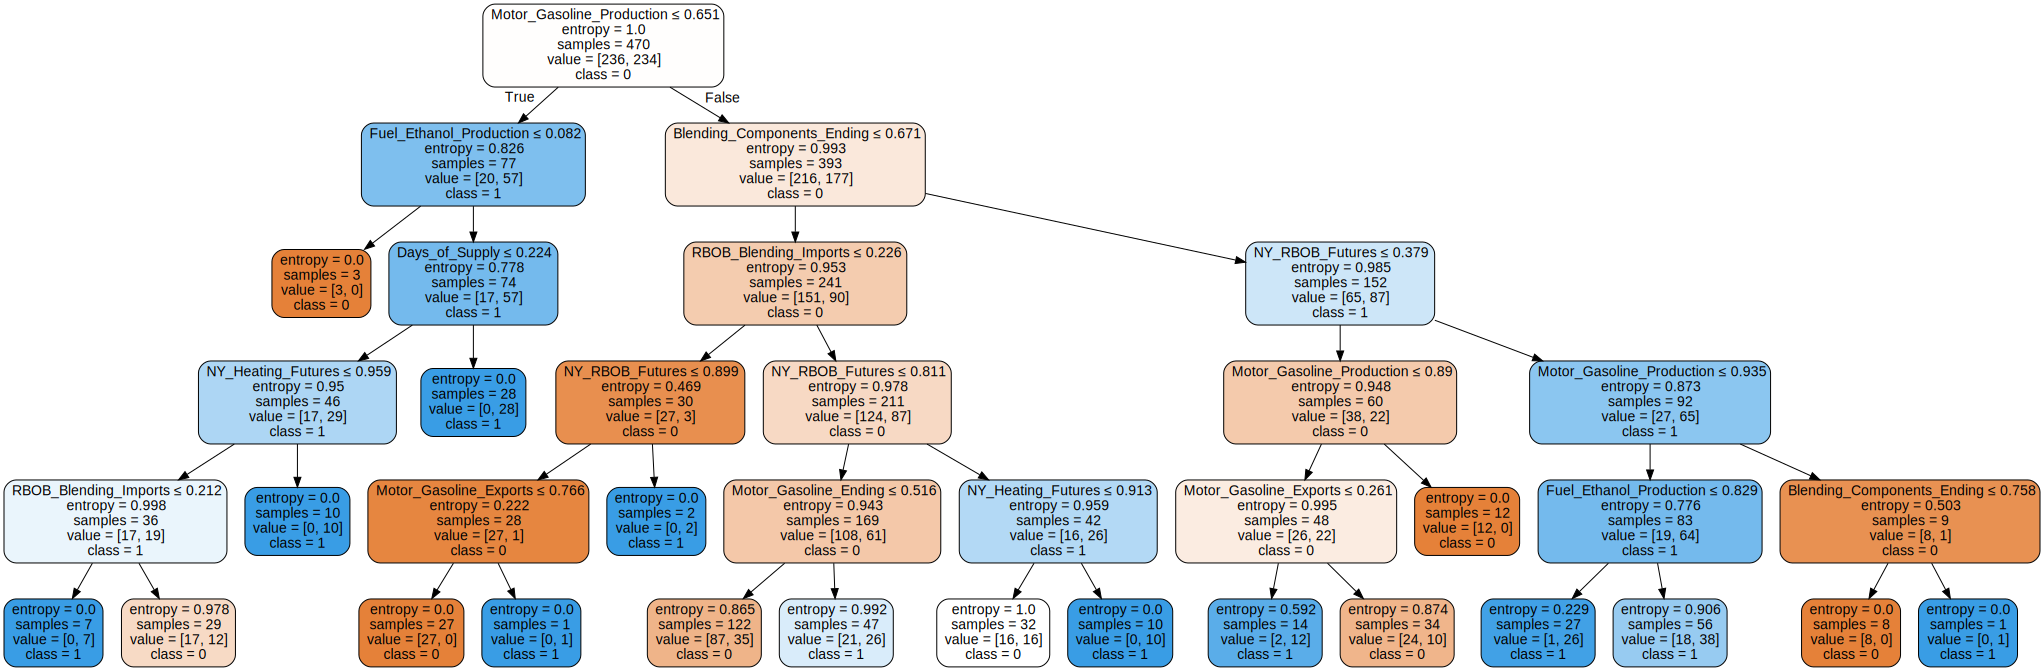

In [8]:
import graphviz 

dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names=new_data.drop('All_Forms_Prices', axis=1).columns,
    class_names=new_data['All_Forms_Prices'].unique().astype(str),
    filled=True, rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [9]:
#del final_fi, decision tree chooses features with highest importance

# Calculating Feature Importance
for i, column in enumerate(new_data.drop('All_Forms_Prices', axis=1)):
    print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': [dt.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi,fi], ignore_index = True)
    except:
        final_fi = fi
        
        
# Ordering the data
final_fi = final_fi.sort_values('Feature Importance Score', ascending = False).reset_index()            
final_fi

Importance of feature NY_Heating_Futures:, 0.099
Importance of feature NY_RBOB_Futures:, 0.165
Importance of feature Commercial_Crude_Imports:, 0.000
Importance of feature Days_of_Supply:, 0.085
Importance of feature Blending_Components_Ending:, 0.094
Importance of feature Motor_Gasoline_Ending:, 0.045
Importance of feature Motor_Gasoline_Exports:, 0.098
Importance of feature RBOB_Blending_Imports:, 0.104
Importance of feature Fuel_Ethanol_Production:, 0.084
Importance of feature Motor_Gasoline_Production:, 0.226


,index,Variable,Feature Importance Score
0,9,Motor_Gasoline_Production,0.225512
1,1,NY_RBOB_Futures,0.165474
2,7,RBOB_Blending_Imports,0.104050
3,0,NY_Heating_Futures,0.098772
4,6,Motor_Gasoline_Exports,0.098298
5,4,Blending_Components_Ending,0.094073
6,3,Days_of_Supply,0.085002
7,8,Fuel_Ethanol_Production,0.083674
8,5,Motor_Gasoline_Ending,0.045146
9,2,Commercial_Crude_Imports,0.000000


In [10]:
# Accuracy on Train
print("Training Accuracy is: ", dt.score(X_train, Y_train))

# Accuracy on Test
print("Testing Accuracy is: ", dt.score(X_test, Y_test))

Training Accuracy is:  0.7553191489361702
Testing Accuracy is:  0.576271186440678


[0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 1 0
 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1
 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0
 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1
 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1
 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0
 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0
 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1
 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1]
[[194  42]
 [ 73 161]]


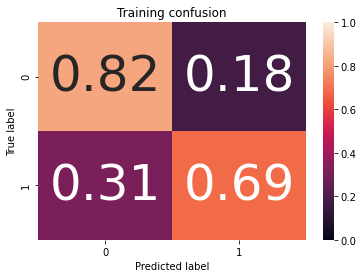

In [11]:
# Confusion Matrix function
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plotting Confusion Matrix
Y_pred = dt.predict(X_train)
print(Y_pred)
print(confusion_matrix(Y_train, Y_pred))

cm = confusion_matrix(Y_train, Y_pred) # Create CM
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis] # Normalize Data
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

Training Accuracy is:  1.0
Testing Accuracy is:  0.6610169491525424


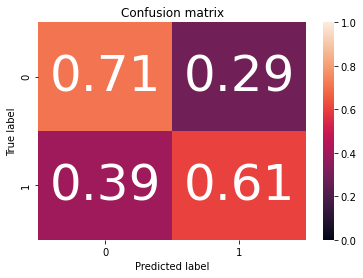

In [12]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, Y_train)
prediction_test = rf.predict(X=X_test)
# source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Accuracy on Train
print("Training Accuracy is: ", rf.score(X_train, Y_train))
# Accuracy on Test
print("Testing Accuracy is: ", rf.score(X_test, Y_test))

# Confusion Matrix
cm = confusion_matrix(Y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

Classification accuracy on test set with max features = 1 and max_depth = None: 0.653
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.610
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.585
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.568
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.602
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.678
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.576
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.593
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.593
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.610
Classification accuracy on test set with max features = log2 and max_depth = None: 0.678
Classification accuracy on test set with max features = log2

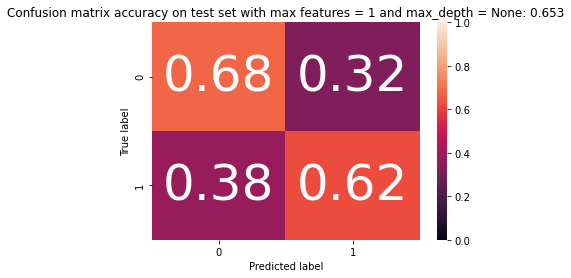

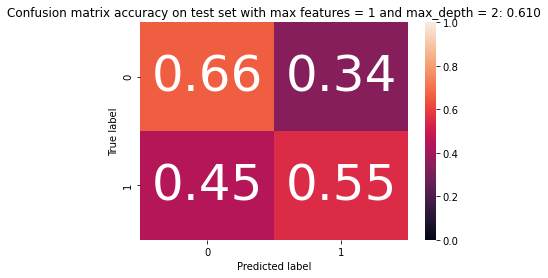

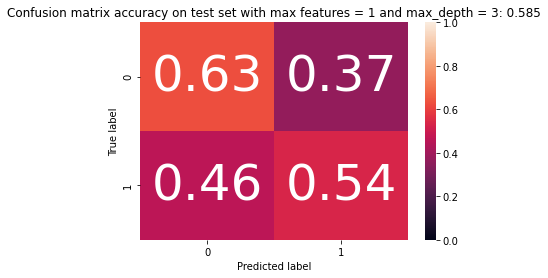

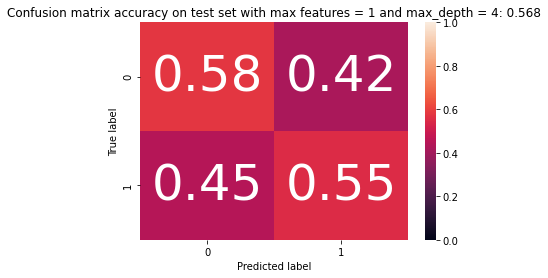

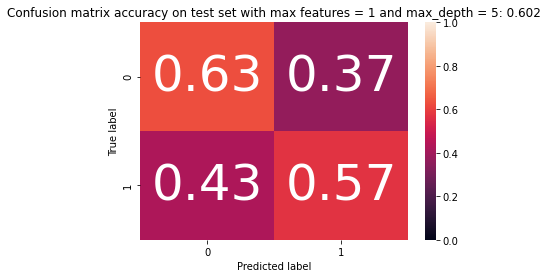

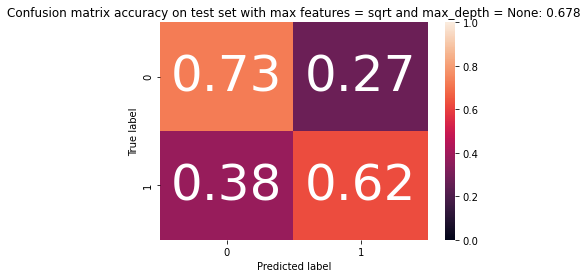

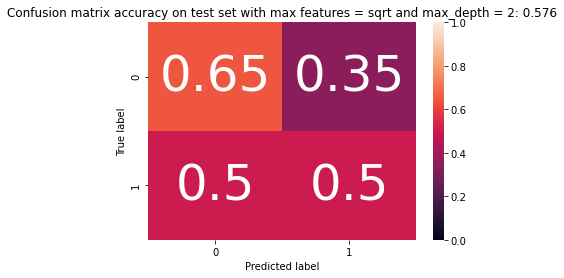

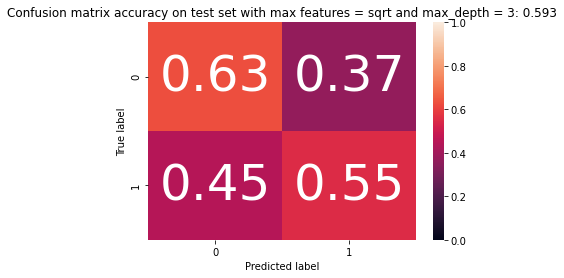

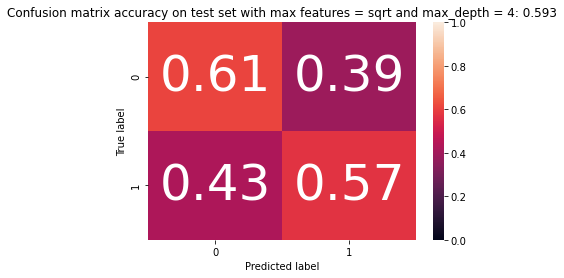

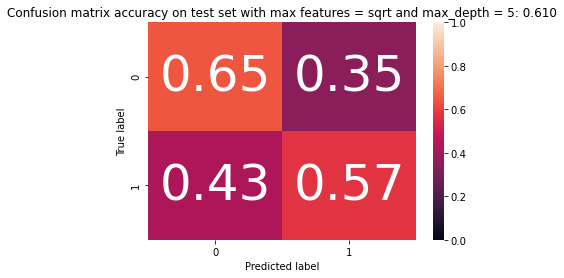

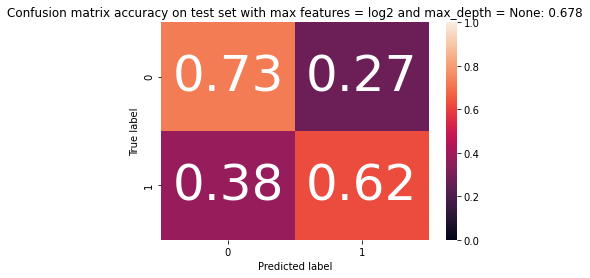

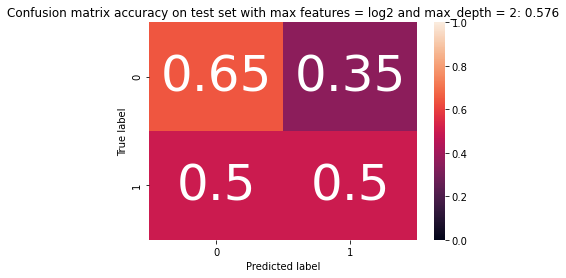

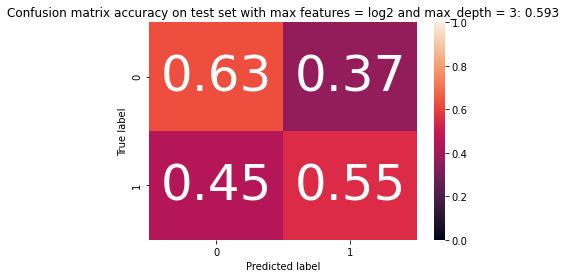

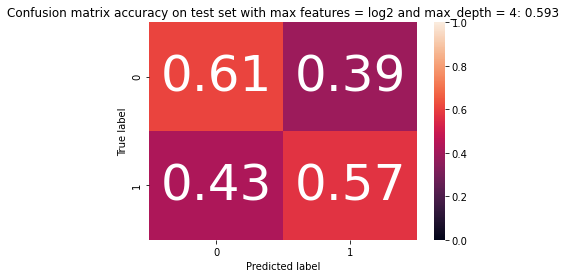

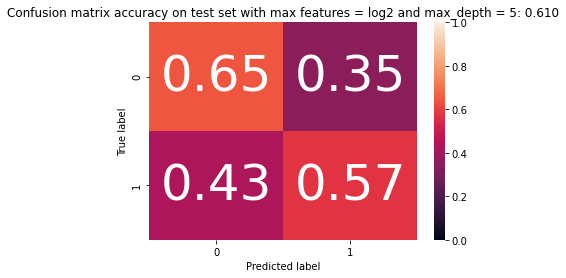

In [13]:
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5]
# We can iterate through all possible combinations of max_features and max_depths with product
for f, d in product(max_features, max_depths):
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=f, max_depth=d, n_jobs=2, random_state=1337)
    rf.fit(X_train, Y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(Y_test,prediction_test)))
    cm = confusion_matrix(Y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_, title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(Y_test,prediction_test)))

In [14]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

classifier = xgb.XGBClassifier(tree_method='hist')

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50],
    "max_depth":[2,3,4,5,6,8,10,12,15,20,25,None],
    "min_child_weight":[1,3,5,7,9,11],
    "gamma":[0.0,0.1,0.2,0.3,0.4,0.5],
    "colsample_bytree":[0.3,0.4,0.5,0.7,0.9]}

clf = RandomizedSearchCV(classifier, param_distributions=params, n_iter=5, scoring='roc_auc', cv=5, verbose=3)
# source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# fitting it
clf.fit(X,Y)

# best parameters
# clf.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[18:19:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=11; total time=   0.0s
[18:19:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=11; total time=   0.0s
[18:19:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with

/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/x

[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.5, max_depth=20, min_child_weight=3; total time=   0.0s
[18:19:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.5, max_depth=20, min_child_weight=3; total time=   0.1s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.5, max_depth=20, min_child_weight=3; total time=   0.1s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting

/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/x

[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.5, max_depth=20, min_child_weight=3; total time=   0.1s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=9; total time=   0.1s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=9; total time=   0.0s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting i

/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/x

[CV 5/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=9; total time=   0.1s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.15, max_depth=4, min_child_weight=11; total time=   0.0s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.15, max_depth=4, min_child_weight=11; total time=   0.0s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Startin

/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/x

[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.4, max_depth=4, min_child_weight=11; total time=   0.1s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.4, max_depth=4, min_child_weight=11; total time=   0.0s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.4, max_depth=4, min_child_weight=11; total time=   0.0s
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting

/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/x

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method='hist',
                                           validate_parameters=None,
                                 

In [15]:
print(clf.best_params_)
# getting the model with the best parameters
clf.best_estimator_

{'min_child_weight': 11, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.4}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=11, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

[18:19:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


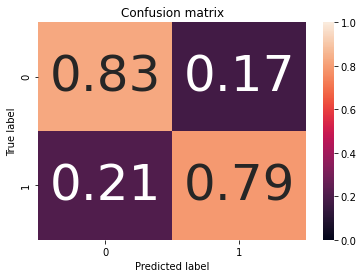

In [16]:
final_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=11, missing=1, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

# fitting it
final_model.fit(X,Y)

pred_xgboost = final_model.predict(X)

# Confusion Matrix
cm = confusion_matrix(Y, pred_xgboost)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

In [18]:
Gas_Data2 = read_csv('/Users/siddharth/Downloads/School Stuff/RBOB UGA/Gas_Data.csv')

Weeks = [date for date in Gas_Data2['Week of']]
All_Formulas_Prices = [price for price in Gas_Data2.All_Forms_Prices]

def np_shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))
#Gas_Data2['All_Forms_Prices'] = np.where(np.shift(np.array(Gas_Data2['All_Forms_Prices']), 1) > np_shift(np.array(Gas_Data2['All_Forms_Prices']), 2), 1, 0)
Gas_Data2['All_Forms_Prices'] = np.where(np.array(Gas_Data2['All_Forms_Prices']) > np_shift(np.array(Gas_Data2['All_Forms_Prices']), 1), 1, 0)

new_data2 = Gas_Data2[['Cushing_Crude_Futures',
       'NY_Heating_Futures', 'NY_RBOB_Futures', 'Crude_Distillation_Capacity',
       'Commercial_Crude_Imports', 'Days_of_Supply', 'Fuel_Ethanol_Ending',
       'Blending_Components_Ending', 'Motor_Gasoline_Ending',
       'Total_Gasoline_Ending', 'Motor_Gasoline_Exports',
       'RBOB_Blending_Imports', 'Total_Imports', 'Fuel_Ethanol_Production',
       'Refinery_Utilization_Capacity', 'Motor_Gasoline_Supplied',
       'Propane_Propylene_Supplied', 'Blending_Components_Inputs',
       'Refinery_Crude_Inputs', 'Motor_Gasoline_Production']]

scale_vars = ['Cushing_Crude_Futures',
       'NY_Heating_Futures', 'NY_RBOB_Futures', 'Crude_Distillation_Capacity',
       'Commercial_Crude_Imports', 'Days_of_Supply', 'Fuel_Ethanol_Ending',
       'Blending_Components_Ending', 'Motor_Gasoline_Ending',
       'Total_Gasoline_Ending', 'Motor_Gasoline_Exports',
       'RBOB_Blending_Imports', 'Total_Imports', 'Fuel_Ethanol_Production',
       'Refinery_Utilization_Capacity', 'Motor_Gasoline_Supplied',
       'Propane_Propylene_Supplied', 'Blending_Components_Inputs',
       'Refinery_Crude_Inputs', 'Motor_Gasoline_Production']

scaler = MinMaxScaler()
new_data2[scale_vars] = scaler.fit_transform(new_data2[scale_vars])

new_data2 = new_data2[['NY_Heating_Futures','NY_RBOB_Futures','Days_of_Supply',
                     'Motor_Gasoline_Ending','Total_Gasoline_Ending','RBOB_Blending_Imports',
                     'Fuel_Ethanol_Production','Refinery_Utilization_Capacity',
                     'Propane_Propylene_Supplied','Motor_Gasoline_Production']]
new_data2.tail()

<ipython-input-18-c641ec303720>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data2[scale_vars] = scaler.fit_transform(new_data2[scale_vars])
/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,NY_Heating_Futures,NY_RBOB_Futures,Days_of_Supply,Motor_Gasoline_Ending,Total_Gasoline_Ending,RBOB_Blending_Imports,Fuel_Ethanol_Production,Refinery_Utilization_Capacity,Propane_Propylene_Supplied,Motor_Gasoline_Production
583,0.555255,0.560732,0.055556,0.152191,0.335181,0.368687,0.700525,0.619952,0.237985,0.791199
584,0.578053,0.577640,0.085185,0.140162,0.386400,0.472222,0.681261,0.748219,0.472496,0.801354
585,0.586940,0.564872,0.088889,0.121234,0.389246,0.661616,0.660245,0.762470,0.361899,0.827798
586,0.630216,0.596273,0.107407,0.209151,0.437251,0.464646,0.772329,0.798100,0.465547,0.829279
587,0.683153,0.631815,0.092593,0.253022,0.408383,0.532828,0.866900,0.729216,0.370006,0.819547


In [19]:
# Making Predictions
pred_xgboost = final_model.predict(new_data2.values)
pred_prob_xgboost = final_model.predict_proba(new_data2.values)

print(pred_xgboost)
# Probabilities
print(pred_prob_xgboost)

# function to select second column for probabilities
def column(matrix, i):
    return [row[i] for row in matrix]

column(pred_prob_xgboost, 1)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0
 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0
 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1
 0 1 0 1 0 0 0 0 0 1 1 1 

[0.5948013,
 0.6434816,
 0.60403633,
 0.67231095,
 0.63678485,
 0.65761274,
 0.6453639,
 0.6566901,
 0.68537414,
 0.7179833,
 0.6141087,
 0.63806593,
 0.6249448,
 0.6646618,
 0.6440566,
 0.63046783,
 0.60136026,
 0.62879086,
 0.6364646,
 0.6364646,
 0.72490996,
 0.70420337,
 0.68505543,
 0.7217923,
 0.68253356,
 0.68245184,
 0.7756411,
 0.8565305,
 0.6453414,
 0.8600261,
 0.8660441,
 0.9136975,
 0.6495902,
 0.6066166,
 0.7049319,
 0.8029549,
 0.7089592,
 0.83711475,
 0.83083856,
 0.8536491,
 0.8025975,
 0.84402794,
 0.77577376,
 0.7763092,
 0.6890019,
 0.67114764,
 0.6990941,
 0.6771802,
 0.7785789,
 0.69143254,
 0.5964902,
 0.6967806,
 0.7121658,
 0.7818108,
 0.76540047,
 0.77996284,
 0.7140916,
 0.6519968,
 0.6257962,
 0.6683452,
 0.6781313,
 0.6101077,
 0.62114286,
 0.5194474,
 0.5722984,
 0.7130605,
 0.59044814,
 0.61687076,
 0.60999906,
 0.746239,
 0.7047828,
 0.6803296,
 0.55146945,
 0.6075448,
 0.5852296,
 0.6117813,
 0.5691221,
 0.7615147,
 0.7983314,
 0.85087025,
 0.8479516,
 

In [20]:
# Joining the raw data witht the predictions

output = new_data2.copy()
output['Predictions - Rise or Fall'] = pred_xgboost
output['Predictions - Probability to Rise'] = column(pred_prob_xgboost, 1)
output['Predictions - Rise or Fall Desc'] = 'Empty'
output['Predictions - Rise or Fall Desc'][output['Predictions - Rise or Fall'] == 0] = 'Fall'
output['Predictions - Rise or Fall Desc'][output['Predictions - Rise or Fall'] == 1] = 'Rise'
output['All_Formulas_Prices'] = All_Formulas_Prices
output['Week_of'] = Weeks 
output

<ipython-input-20-c6d7ddec6d5b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Predictions - Rise or Fall Desc'][output['Predictions - Rise or Fall'] == 0] = 'Fall'
<ipython-input-20-c6d7ddec6d5b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Predictions - Rise or Fall Desc'][output['Predictions - Rise or Fall'] == 1] = 'Rise'


,NY_Heating_Futures,NY_RBOB_Futures,Days_of_Supply,Motor_Gasoline_Ending,Total_Gasoline_Ending,RBOB_Blending_Imports,Fuel_Ethanol_Production,Refinery_Utilization_Capacity,Propane_Propylene_Supplied,Motor_Gasoline_Production,Predictions - Rise or Fall,Predictions - Probability to Rise,Predictions - Rise or Fall Desc,All_Formulas_Prices,Week_of
0,0.498068,0.526225,0.074074,0.504098,0.377849,0.300505,0.497373,0.819477,0.184134,0.767929,1,0.594801,Rise,2.771,7/12/10
1,0.513138,0.535887,0.074074,0.590542,0.394333,0.654040,0.523643,0.843230,0.266358,0.716522,1,0.643482,Rise,2.775,7/19/10
2,0.516229,0.548999,0.070370,0.577628,0.395674,0.381313,0.488616,0.821853,0.268095,0.770679,1,0.604036,Rise,2.801,7/26/10
3,0.514297,0.546239,0.074074,0.586119,0.406422,0.603535,0.588441,0.836105,0.147655,0.754813,1,0.672311,Rise,2.788,8/2/10
4,0.573802,0.572464,0.074074,0.594964,0.412452,0.431818,0.576182,0.762470,0.140127,0.734292,1,0.636785,Rise,2.835,8/9/10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0.555255,0.560732,0.055556,0.152191,0.335181,0.368687,0.700525,0.619952,0.237985,0.791199,1,0.529814,Rise,3.262,9/13/21
584,0.578053,0.577640,0.085185,0.140162,0.386400,0.472222,0.681261,0.748219,0.472496,0.801354,0,0.493687,Fall,3.280,9/20/21
585,0.586940,0.564872,0.088889,0.121234,0.389246,0.661616,0.660245,0.762470,0.361899,0.827798,1,0.554542,Rise,3.271,9/27/21
586,0.630216,0.596273,0.107407,0.209151,0.437251,0.464646,0.772329,0.798100,0.465547,0.829279,1,0.647392,Rise,3.285,10/4/21


In [ ]:
output.tail(50)